In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
T = 1000
dt = 0.1
time = np.arange(0, T, dt)
steps = len(time)

In [39]:
def input_signal(t):
    # sine wave with gaussian noise
    return np.sin(0.02 * t)

I = input_signal(time)

In [40]:
np.random.seed(42)

N = 100
r_params = np.random.uniform(0.5, 2.0, size=N)
a_params = np.random.uniform(-1.0, 1.0, size=N)
b_params = np.random.uniform(0.5, 1.5, size=N)
R_params = np.random.uniform(0.5, 2.0, size=N)
sigma_params = np.random.uniform(0.01, 0.05, size=N)

# introduce a parameter lambda 
lambda_params = np.random.uniform(0.1, 1.0, size=N)

V = np.zeros((N, steps))
W = np.zeros((N, steps))

V[:, 0] = 0.0
W[:, 0] = 0.0

# euler-maruyama integration
for n in range(steps - 1):
    dv = V[:, n] - (V[:, n]**3) / 3 - W[:, n] + R_params * I[n]
    dw = (1.0 / r_params) * (V[:, n] + a_params - b_params * W[:, n])
    noise = sigma_params * np.sqrt(dt) * np.random.randn(N)

    V[:, n+1] = V[:, n] + dt * dv + noise
    W[:, n+1] = W[:, n] + dt * dw

In [41]:
# sliding window analysis on the output of the neurons
dVdt = np.diff(V, axis=1) / dt

window_size = 100
window_steps = int(window_size / dt)
num_windows = steps - window_steps + 1

cov_lambda_V = np.zeros(num_windows)
cov_lambda_dVdt = np.zeros(num_windows)

for w in range(num_windows):
    start = w
    end = w + window_steps

    mean_V_window = np.mean(V[:, start:end], axis=1)
    mean_dVdt_window = np.mean(dVdt[:, start:end-1], axis=1)

    cov_lambda_V[w] = np.cov(lambda_params, mean_V_window, ddof=0)[0, 1]
    cov_lambda_dVdt[w] = np.cov(lambda_params, mean_dVdt_window, ddof=0)[0, 1]

window_time = time[window_steps // 2 : window_steps // 2 + num_windows]


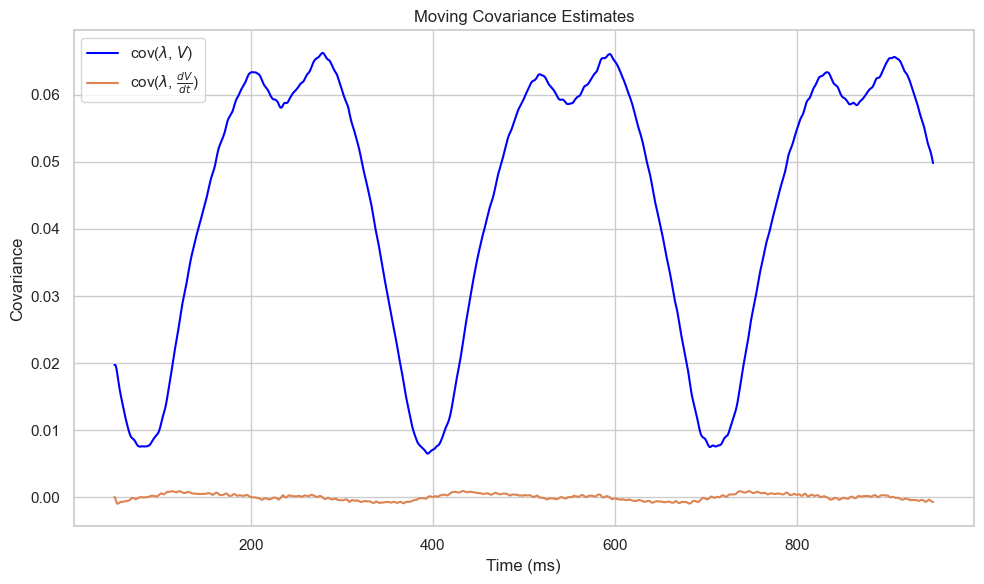

In [42]:
# plotting the moving covariance estimates
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x=window_time, y=cov_lambda_V, label=r'cov($\lambda$, $V$)', color='blue')
sns.lineplot(x=window_time, y=cov_lambda_dVdt, label=r'cov($\lambda$, $\frac{dV}{dt}$)', color='C1')
plt.xlabel('Time (ms)')
plt.ylabel('Covariance')
plt.title('Moving Covariance Estimates')
plt.legend()
plt.tight_layout()
plt.show()

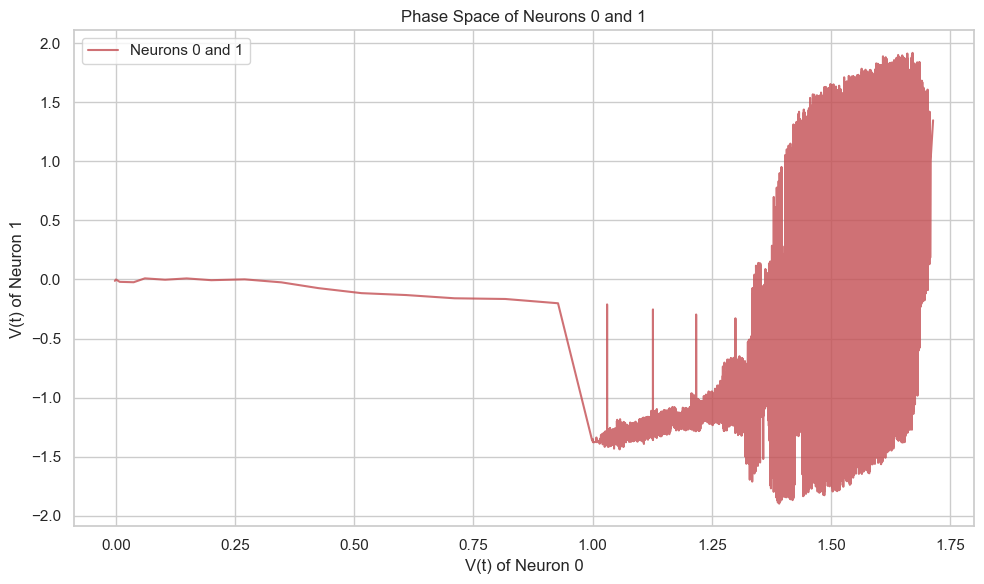

/var/folders/nf/hy2hshms2_v1kl4rj3cq7q840000gn/T/ipykernel_670/1155087141.py:17: RuntimeWarning: divide by zero encountered in log
  sns.lineplot(x=time, y=np.log(np.abs(V[0, :] - V[1, :])), label='Log Difference', color='C4', alpha=0.8)


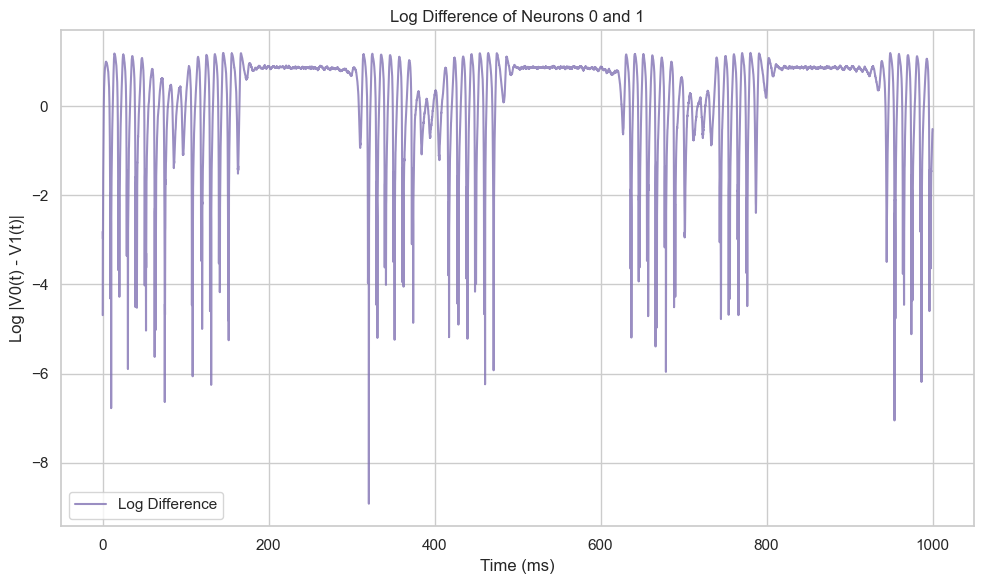

In [43]:
# -------------------------------
# Phase Space Plot: Neurons 0 vs. 1
# -------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(x=V[0, :], y=V[1, :], label='Neurons 0 and 1', color='C3', alpha=0.8)
plt.xlabel('V(t) of Neuron 0')
plt.ylabel('V(t) of Neuron 1')
plt.title('Phase Space of Neurons 0 and 1')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Log Difference Plot: Neuron 0 vs. Neuron 1
# -------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(x=time, y=np.log(np.abs(V[0, :] - V[1, :])), label='Log Difference', color='C4', alpha=0.8)
plt.xlabel('Time (ms)')
plt.ylabel('Log |V0(t) - V1(t)|')
plt.title('Log Difference of Neurons 0 and 1')
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
# calculate the Lyapunov exponent
lyapunov = np.zeros(steps)
for j in range(steps - 1):
    lyapunov[j] = np.log(np.abs(V[0, j] - V[1, j])) / dt

lyapunov = np.mean(lyapunov)
if lyapunov > 0:
    print(f'Lyapunov exponent: {lyapunov:.4f} (chaotic)')
else:
    print(f'Lyapunov exponent: {lyapunov:.4f} (non-chaotic)')

Lyapunov exponent: -inf (non-chaotic)


/var/folders/nf/hy2hshms2_v1kl4rj3cq7q840000gn/T/ipykernel_670/1047307470.py:4: RuntimeWarning: divide by zero encountered in log
  lyapunov[j] = np.log(np.abs(V[0, j] - V[1, j])) / dt


In [45]:
# regression analysis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# target var, moving avg of V across neurons
move_mean_V = np.zeros(num_windows)
for w in range(num_windows):
    move_mean_V[w] = np.mean(V[:, w:w + window_steps])

# construct the feature matrix: [cov(lambda, V), cov(lambda, dV/dt)]

# train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    np.column_stack((cov_lambda_V, cov_lambda_dVdt)), move_mean_V, test_size=0.2, random_state=42
)

# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')


Mean Squared Error: 0.0838
R^2 Score: 0.8920


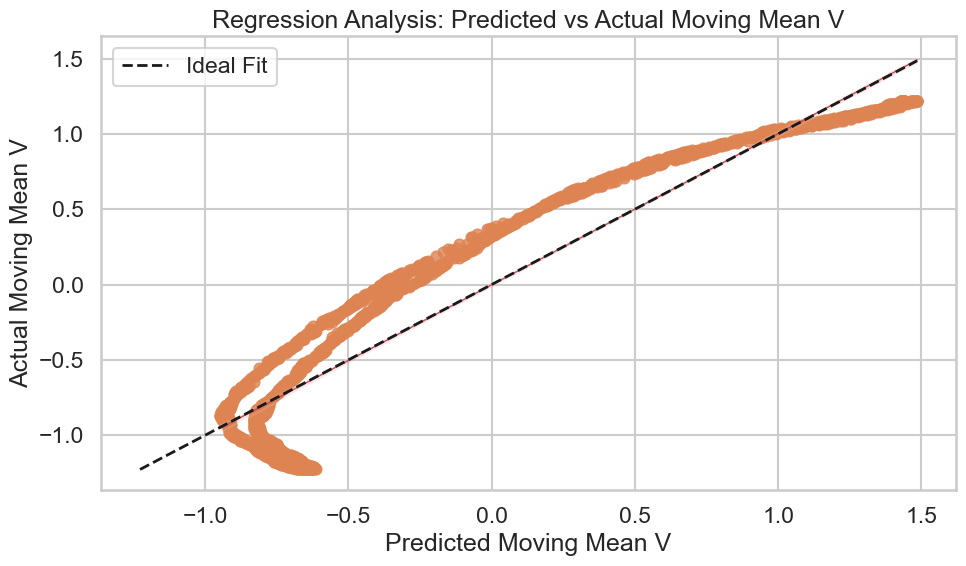

In [48]:
# plotting the regression results
sns.set_theme(style="whitegrid", context='talk')
plt.figure(figsize=(10, 6))

sns.regplot(
    x=y_pred,
    y=y_test,
    ci=95,
    scatter_kws={'s': 60, 'alpha': 0.8, 'color': 'C1'},
    line_kws={'color': 'C3', 'lw': 1}
)
plt.xlabel('Predicted Moving Mean V')
plt.ylabel('Actual Moving Mean V')
plt.title('Regression Analysis: Predicted vs Actual Moving Mean V')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Fit')
plt.legend()
plt.tight_layout()
plt.show()


In [54]:
# trying other regression models

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# construct feature matrix X and target y
X = np.column_stack((cov_lambda_V, cov_lambda_dVdt))
y = move_mean_V

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# nonlinear polynomial regression
deg = 2
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
    ('lin_reg', LinearRegression())
])

poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f'Polynomial Regression (degree {deg}) - Mean Squared Error: {mse_poly:.4f}')
print(f'Polynomial Regression (degree {deg}) - R^2 Score: {r2_poly:.4f}')

Polynomial Regression (degree 2) - Mean Squared Error: 0.0483
Polynomial Regression (degree 2) - R^2 Score: 0.9379


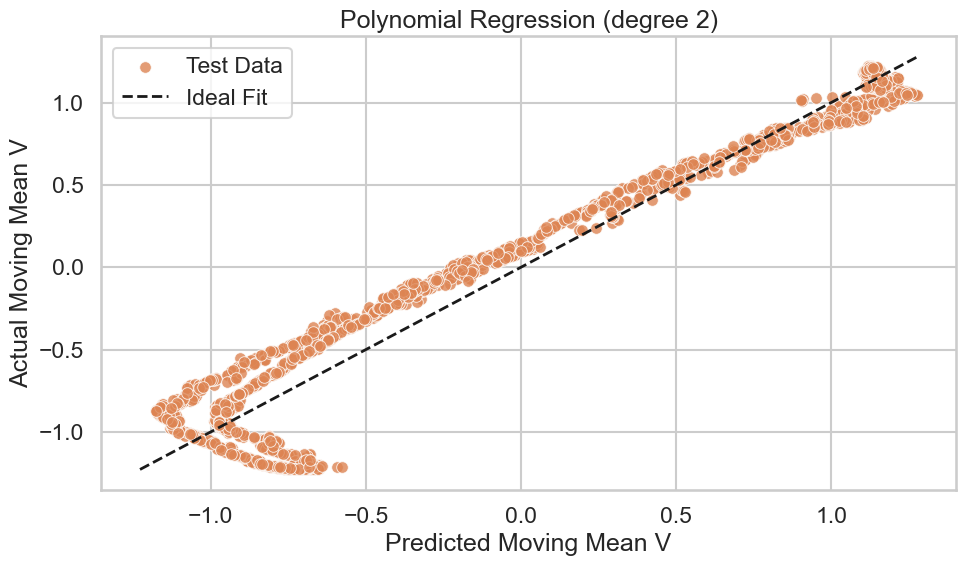

In [55]:
sns.set_theme(style="whitegrid", context='talk')
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x = y_pred_poly,
    y = y_test,
    color='C1',
    s=70,
    alpha=0.8,
    label='Test Data'
)

min_val = min(y_test.min(), y_pred_poly.min())
max_val = max(y_test.max(), y_pred_poly.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Predicted Moving Mean V')
plt.ylabel('Actual Moving Mean V')
plt.title(f'Polynomial Regression (degree {deg})')
plt.legend()
plt.tight_layout()
plt.show()